In [4]:
library(ggplot2)
library(patchwork)

save_dir = "/sc/arion/projects/YuanLab/gcproj/xuan/01.spatial_omics/03.downstream/1.align_H3K4me3_to_H3K27me3/"
setwd(save_dir)

In [5]:
#' @title locs_shift_rotate
#' @description tranfer xy to satrt with c(0,0),shift and rotate for spatial locations 
#' @param locs Data.table for store spatial coordinates with header: cell_ID, sdimx, sdimy
#' @param xtranslate The distance for shift all spots at x coordinate
#' @param ytranslate The distance for shift all spots at y coordinate
#' @param angle angle for rotation
#' @return Data.table with 3 columns: cell_ID, sdimx, sdimy
locs_shift_rotate <- function(
    locs,
    x_shift = 0,
    y_shift = 0,
    angle = 0
){
    # transfer xy coordiante start from (0,0)
    locs$sdimx <- locs$sdimx - min(locs$sdimx)
    locs$sdimy <- locs$sdimy - min(locs$sdimy)
    
    # shift xy coordinate
    if (x_shift != 0 ){locs$sdimx <- locs$sdimx + x_shift}
    if (y_shift != 0 ){locs$sdimy <- locs$sdimy + y_shift}
    
    # rotate coordinate
    if (angle != 0){
        m1 = data.frame(locs$sdimx, locs$sdimy)
        p <- c((max(m1[,1]) - min(m1[,1]))/2 + min(m1[,1]), (max(m1[,2]) - min(m1[,2]))/2 + min(m1[,2]))
        
        #rotation matrix
        rad <- REdaS::deg2rad(angle)
        rotm <- matrix(c(cos(rad),sin(rad),-sin(rad),cos(rad)),ncol=2)
        
        #shift, rotate, shift back
        m2 <- t(rotm %*% (t(m1)-p)+p)
        locs$sdimx = m2[,1]
        locs$sdimy = m2[,2]
    }
    return(locs)
}

#' @title locs_align
#' @description align spots between locs_1 and locs_2
#' @param locs1 Data.table for store spatial coordinates with header: cell_ID, sdimx, sdimy
#' @param locs2 Data.table for store spatial coordinates with header: cell_ID, sdimx, sdimy
#' @return Data.table of aligned results with colunms: aligned_name, cell_ID_ref, cell_ID_aligned, align_distance, x.ref, y.ref, x.align, y.align
locs_align <- function(
    locs1,
    locs2){
    # compute diameter for each spots
    x_len = unique(sort(locs1$sdimx))
    diameter = mean(x_len[2:length(x_len)] - x_len[1:length(x_len)-1])

    # map locs1 to locs2, iter for locs1
    l <- lapply(1:dim(locs1)[1], function(x) {
        site1 = locs1[x]
        distance = sqrt((locs2$sdimx - site1$sdimx)^2 + (locs2$sdimy - site1$sdimy)^2)
        dist_min = min(distance)
        if (dist_min < diameter){
            cell_ID1 = site1$cell_ID
            cell_ID2 = locs2[which(distance == dist_min)]$cell_ID
            return(c(cell_ID1, cell_ID2, dist_min))
        }
    })
    
    # list to data.table
    cell_ID_align = data.table::data.table(matrix(unlist(l), ncol= 3, byrow = TRUE))

    # change columns
    data.table::setnames(cell_ID_align, new = c('cell_ID_ref', 'cell_ID_aligned', 'align_distance'))
    data.table::setnames(locs1, new = c('cell_ID_ref', 'x.ref', 'y.ref'))
    data.table::setnames(locs2, new = c('cell_ID_aligned', 'x.align', 'y.align'))

    # unique align spots
    #cell_ID_align = cell_ID_align[, .SD[which.min(align_distance)], by = .(cell_ID_ref)]
    #cell_ID_align = cell_ID_align[, .SD[which.min(align_distance)], by = .(cell_ID_aligned)]

    # merge coordinate from locs1 and locs2
    cell_ID_align = data.table::merge.data.table(cell_ID_align, locs1, by = 'cell_ID_ref')
    cell_ID_align = data.table::merge.data.table(cell_ID_align, locs2, by = 'cell_ID_aligned')
    data.table::setorder(cell_ID_align, 'x.ref', 'y.ref')
    cell_ID_align[, aligned_name := paste0("aligned_", 1:nrow(cell_ID_align))] 
    cell_ID_align = cell_ID_align[, .(aligned_name, cell_ID_ref, cell_ID_aligned, align_distance, x.ref, y.ref, x.align, y.align)]
    
    return(cell_ID_align)
}

# Load coordinate

In [6]:
# load spatial coordinates for H3K4me3
f = "/sc/arion/projects/YuanLab/gcproj/xuan/00.data/01.spatial_omics/spatial_CUT_Tag/H3K4me3_E11_50um/processed_data/spatial/tissue_positions_list.csv"
locs = data.table::fread(f)
locs[, V1 := paste0('H3K4me3#',V1,'-1')] # modify cell_ID 
locs = locs[V2 == 1] # select in-tissue spots
locs = locs[, .(V1, V6, -V5)]
data.table::setnames(locs, new=c("cell_ID","sdimx","sdimy"))
locs_1 = data.table::copy(locs)
dim(locs_1)
head(locs_1)


[1] 2122    3

cell_ID,sdimx,sdimy
<chr>,<int>,<int>
H3K4me3#AACGTGATAACGTGAT-1,1618,-398
H3K4me3#AACGTGATAAACATCG-1,1618,-420
H3K4me3#AACGTGATATGCCTAA-1,1618,-442
H3K4me3#AACGTGATAGTGGTCA-1,1618,-464
H3K4me3#AACGTGATACCACTGT-1,1618,-486
H3K4me3#AACGTGATACATTGGC-1,1618,-508


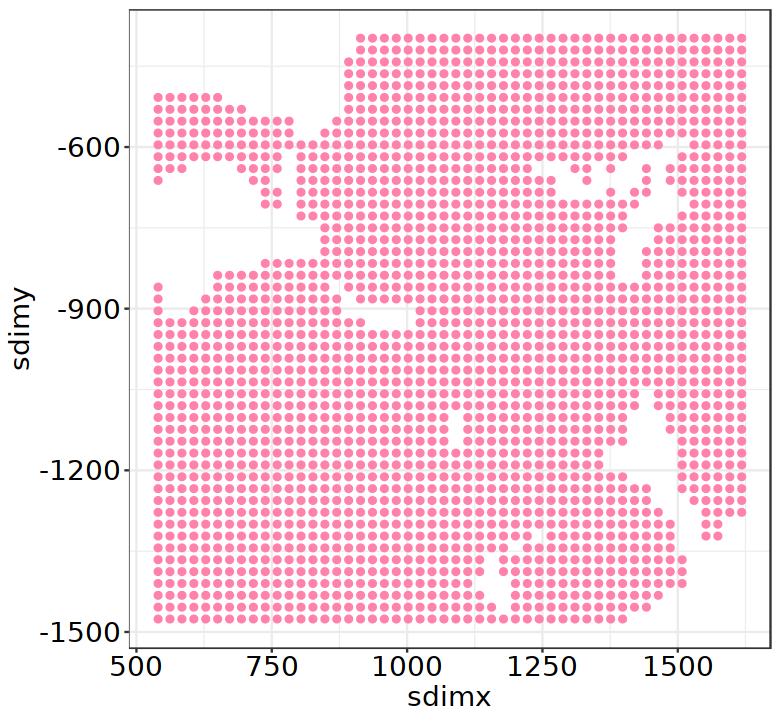

In [7]:
p <- ggplot(locs_1, aes(x = sdimx, y = sdimy)) 
p <- p + geom_point(color="PaleVioletRed1") 
p = p + theme_bw()
p <- p + theme(axis.text = element_text(size =rel(1.5), colour = 'black'),
               axis.title = element_text(size =rel(1.5), colour = 'black'),
               plot.title = element_text(size =rel(2), colour = 'black'),
               legend.text = element_text(size =rel(1.5), colour = 'black'),
               legend.title = element_blank(),
               #panel.grid = element_blank(),
               #panel.background = element_blank()
) 
options(repr.plot.width = 6.5, repr.plot.height = 6)
p

In [8]:
# load spatial coordinates for H3K27me3
f = "/sc/arion/projects/YuanLab/gcproj/xuan/00.data/01.spatial_omics/spatial_CUT_Tag/H3K27me3_E11_50um/processed_data/spatial/tissue_positions_list.csv"
locs = data.table::fread(f)
locs[, V1 := paste0('H3K27me3#',V1,'-1')] # modify cell_ID 
locs = locs[V2 == 1] # select in-tissue spots
locs = locs[, .(V1, V6, -V5)]
data.table::setnames(locs, new=c("cell_ID","sdimx","sdimy"))
locs_2 = data.table::copy(locs)
dim(locs_2)
head(locs_2)

[1] 2135    3

cell_ID,sdimx,sdimy
<chr>,<int>,<int>
H3K27me3#AACGTGATAACGTGAT-1,1601,-214
H3K27me3#AACGTGATAAACATCG-1,1601,-235
H3K27me3#AACGTGATATGCCTAA-1,1601,-256
H3K27me3#AACGTGATAGTGGTCA-1,1601,-277
H3K27me3#AACGTGATACAAGCTA-1,1601,-403
H3K27me3#AACGTGATCTGTAGCC-1,1601,-424


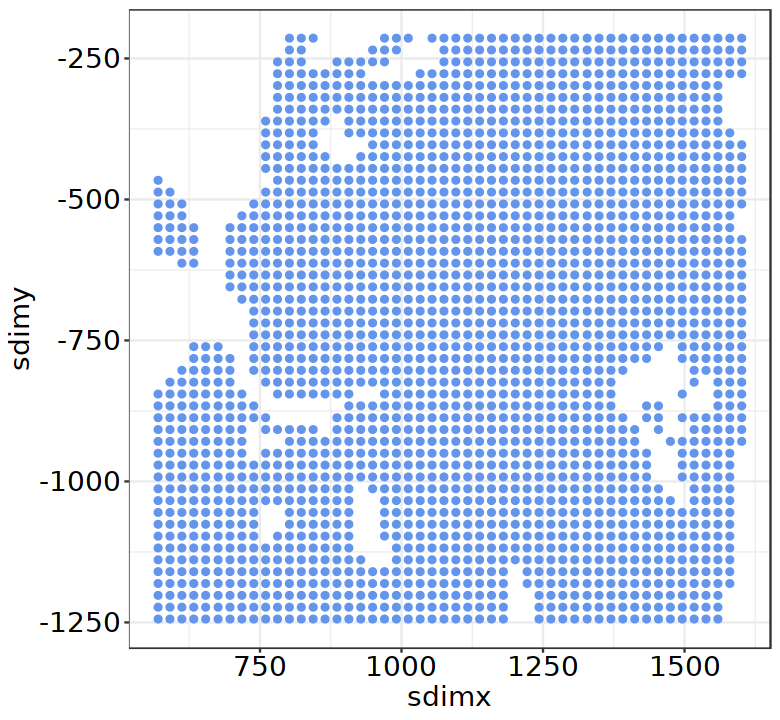

In [9]:
p <- ggplot(locs_2, aes(x = sdimx, y = sdimy)) 
p <- p + geom_point(color="CornflowerBlue") 
p = p + theme_bw()
p <- p + theme(axis.text = element_text(size =rel(1.5), colour = 'black'),
               axis.title = element_text(size =rel(1.5), colour = 'black'),
               plot.title = element_text(size =rel(2), colour = 'black'),
               legend.text = element_text(size =rel(1.5), colour = 'black'),
               legend.title = element_blank(),
               #panel.grid = element_blank(),
               #panel.background = element_blank()
) 
options(repr.plot.width = 6.5, repr.plot.height = 6)
p

# Rotate and shift to zero

In [10]:
locs_H3K4me3 = locs_shift_rotate(locs = locs_1, 
                                 x_shift = 0,
                                 y_shift = 0,
                                 angle = 0
                                )

locs_H3K27me3 = locs_shift_rotate(locs = locs_2, 
                                 x_shift = 162,
                                 y_shift = 176,
                                 angle = 1.8
                                )

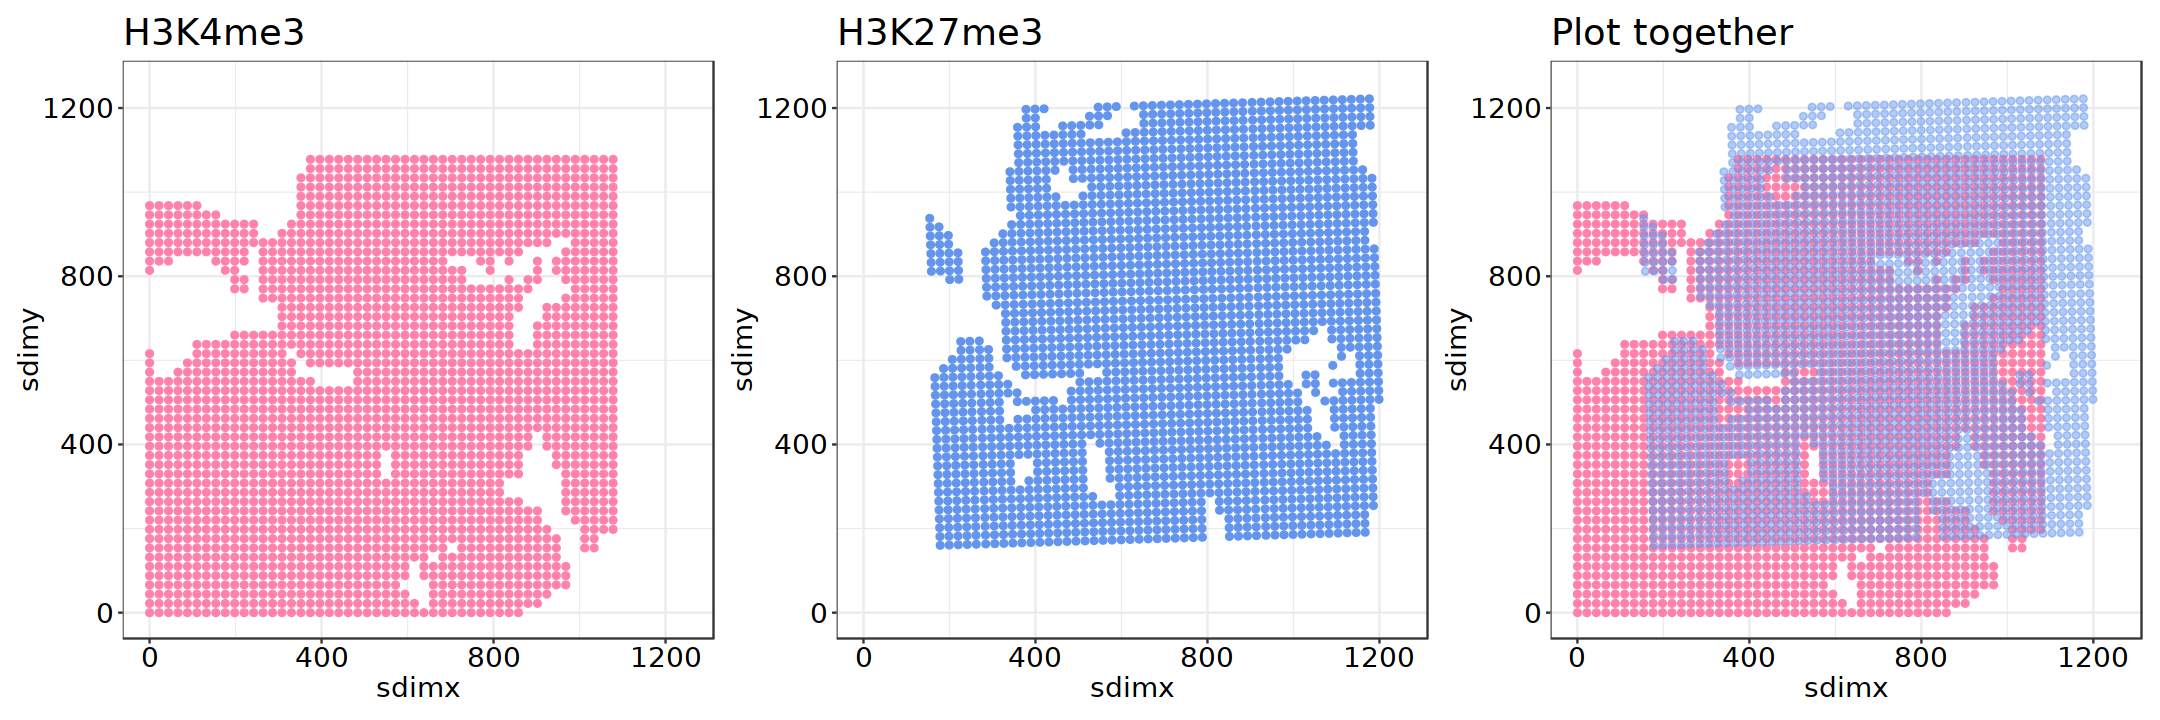

In [11]:
# plot H3K4me3
p <- ggplot(locs_H3K4me3, aes(x = sdimx, y = sdimy)) 
p <- p + geom_point(color="PaleVioletRed1") 
p = p + theme_bw()
p <- p + theme(axis.text = element_text(size =rel(1.5), colour = 'black'),
               axis.title = element_text(size =rel(1.5), colour = 'black'),
               plot.title = element_text(size =rel(2), colour = 'black'),
               legend.text = element_text(size =rel(1.5), colour = 'black'),
               legend.title = element_blank(),
               #panel.grid = element_blank(),
               #panel.background = element_blank()
) 
#p = p + xlim(0,1250) + ylim(0,1250)
p = p + labs(title = "H3K4me3")
p1 = p

# plot H3K27me3
p <- ggplot(locs_H3K27me3, aes(x = sdimx, y = sdimy)) 
p <- p + geom_point(color="CornflowerBlue") 
p = p + theme_bw()
p <- p + theme(axis.text = element_text(size =rel(1.5), colour = 'black'),
               axis.title = element_text(size =rel(1.5), colour = 'black'),
               plot.title = element_text(size =rel(2), colour = 'black'),
               legend.text = element_text(size =rel(1.5), colour = 'black'),
               legend.title = element_blank(),
               #panel.grid = element_blank(),
               #panel.background = element_blank()
) 
#p = p + xlim(0,1250) + ylim(0,1250)
p = p + labs(title = "H3K27me3")
p2 = p

# plot two togerher
p <- ggplot(locs_H3K4me3, aes(x = sdimx, y = sdimy)) 
p <- p + geom_point(color="PaleVioletRed1") 
p = p + theme_bw()
p <- p + theme(axis.text = element_text(size =rel(1.5), colour = 'black'),
               axis.title = element_text(size =rel(1.5), colour = 'black'),
               plot.title = element_text(size =rel(2), colour = 'black'),
               legend.text = element_text(size =rel(1.5), colour = 'black'),
               legend.title = element_blank(),
               #panel.grid = element_blank(),
               #panel.background = element_blank()
) 
p = p + geom_point(data = locs_H3K27me3, aes(x = sdimx,y = sdimy),
                   color="CornflowerBlue",alpha = 0.5,#shape=17
                  )
#p = p + xlim(0,1250) + ylim(0,1250)
p = p + labs(title = "Plot together")
p3 = p

options(repr.plot.width = 18, repr.plot.height = 6)
lims = c(0,1250)
p1 = p1 + xlim(lims) + ylim(lims)
p2 = p2 + xlim(lims) + ylim(lims)
p3 = p3 + xlim(lims) + ylim(lims)

p1| p2 | p3


In [13]:
f = "/sc/arion/projects/YuanLab/gcproj/xuan/01.spatial_omics/00.MS_figures/20230605_v3/S3A.Spat_align.pdf"
pdf(f, width = 18, height = 6)
p1| p2 | p3
dev.off()

png 
  2

# Align H3K27me3 to H3K4me3

In [14]:
locs1 = data.table::copy(locs_H3K4me3)
locs2 = data.table::copy(locs_H3K27me3)

dim(locs1)
head(locs1)

dim(locs2)
head(locs2)

[1] 2122    3

cell_ID,sdimx,sdimy
<chr>,<int>,<int>
H3K4me3#AACGTGATAACGTGAT-1,1078,1078
H3K4me3#AACGTGATAAACATCG-1,1078,1056
H3K4me3#AACGTGATATGCCTAA-1,1078,1034
H3K4me3#AACGTGATAGTGGTCA-1,1078,1012
H3K4me3#AACGTGATACCACTGT-1,1078,990
H3K4me3#AACGTGATACATTGGC-1,1078,968


[1] 2135    3

cell_ID,sdimx,sdimy
<chr>,<dbl>,<dbl>
H3K27me3#AACGTGATAACGTGAT-1,1176.569,1221.938
H3K27me3#AACGTGATAAACATCG-1,1177.229,1200.948
H3K27me3#AACGTGATATGCCTAA-1,1177.888,1179.959
H3K27me3#AACGTGATAGTGGTCA-1,1178.548,1158.969
H3K27me3#AACGTGATACAAGCTA-1,1182.506,1033.031
H3K27me3#AACGTGATCTGTAGCC-1,1183.165,1012.042


In [15]:
locs_align <- function(
    locs1,
    locs2){
    # compute diameter for each spots
    x_locs = unique(sort(locs1$sdimx))
    spot_len = x_locs[2] - x_locs[1]

    # map locs1 to locs2, iter for locs1
    l <- lapply(1:dim(locs1)[1], function(x) {
        site1 = locs1[x]
        distance = sqrt((locs2$sdimx - site1$sdimx)^2 + (locs2$sdimy - site1$sdimy)^2)
        dist_min = min(distance)
        if (dist_min < spot_len){
            cell_ID1 = site1$cell_ID
            cell_ID2 = locs2[which(distance == dist_min)]$cell_ID
            return(c(cell_ID1, cell_ID2, dist_min))
        }
    })
    
    # list to data.table
    cell_ID_align = data.table::data.table(matrix(unlist(l), ncol= 3, byrow = TRUE))

    # change columns
    data.table::setnames(cell_ID_align, new = c('ref', 'aligned', 'align_distance'))
    data.table::setnames(locs1, new = c('ref', 'x.ref', 'y.ref'))
    data.table::setnames(locs2, new = c('aligned', 'x.align', 'y.align'))

    # unique align spots
    #cell_ID_align = cell_ID_align[, .SD[which.min(align_distance)], by = .(cell_ID_ref)]
    #cell_ID_align = cell_ID_align[, .SD[which.min(align_distance)], by = .(cell_ID_aligned)]

    # merge coordinate from locs1 and locs2
    cell_ID_align = data.table::merge.data.table(cell_ID_align, locs1, by = 'ref')
    cell_ID_align = data.table::merge.data.table(cell_ID_align, locs2, by = 'aligned')
    data.table::setorder(cell_ID_align, 'x.ref', 'y.ref')
    cell_ID_align[, aligned_name := paste0("aligned_", 1:nrow(cell_ID_align))] 
    cell_ID_align = cell_ID_align[, .(aligned_name, ref, aligned, align_distance, x.ref, y.ref, x.align, y.align)]
    cell_ID_align[, align_distance := as.numeric(align_distance)]
    
    return(cell_ID_align)
}

In [16]:
locs1 = data.table::copy(locs_H3K4me3)
locs2 = data.table::copy(locs_H3K27me3)

cell_ID_align = locs_align(locs1 = data.table::copy(locs_H3K4me3),
                           locs2 = data.table::copy(locs_H3K27me3))

dim(cell_ID_align)
head(cell_ID_align)

[1] 1571    8

aligned_name,ref,aligned,align_distance,x.ref,y.ref,x.align,y.align
<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
aligned_1,H3K4me3#CTCAATGACCTCCTGA-1,H3K27me3#GCCACATAGAATCTGA-1,21.88586,154,242,175.7924,244.0204
aligned_2,H3K4me3#CTCAATGACCGTGAGA-1,H3K27me3#GCCACATACTGGCATA-1,21.15690,154,264,175.1328,265.0101
aligned_3,H3K4me3#CTCAATGACCGAAGTA-1,H3K27me3#GCCACATACTGAGCCA-1,20.47315,154,286,174.4732,285.9997
aligned_4,H3K4me3#CTCAATGACCAGTTCA-1,H3K27me3#GCCACATACTCAATGA-1,19.83929,154,308,173.8135,306.9893
aligned_5,H3K4me3#CTCAATGACATACCAA-1,H3K27me3#GCCACATACGCATACA-1,19.26023,154,330,173.1539,327.9790
aligned_6,H3K4me3#CTCAATGACAGCGTTA-1,H3K27me3#GCCACATACGACTGGA-1,18.74107,154,352,172.4943,348.9686


In [17]:
length(unique(cell_ID_align$ref))
length(unique(cell_ID_align$aligned))

[1] 1571

[1] 1482

In [18]:
summary(cell_ID_align$align_distance)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2569  6.1141  8.7931  8.7228 10.8844 21.9561 

In [58]:
f <- paste0(save_dir,"/1.algined_cell_ID.csv")
write.table(cell_ID_align,file=f,quote=FALSE, row.names=FALSE,sep = "\t") 